No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


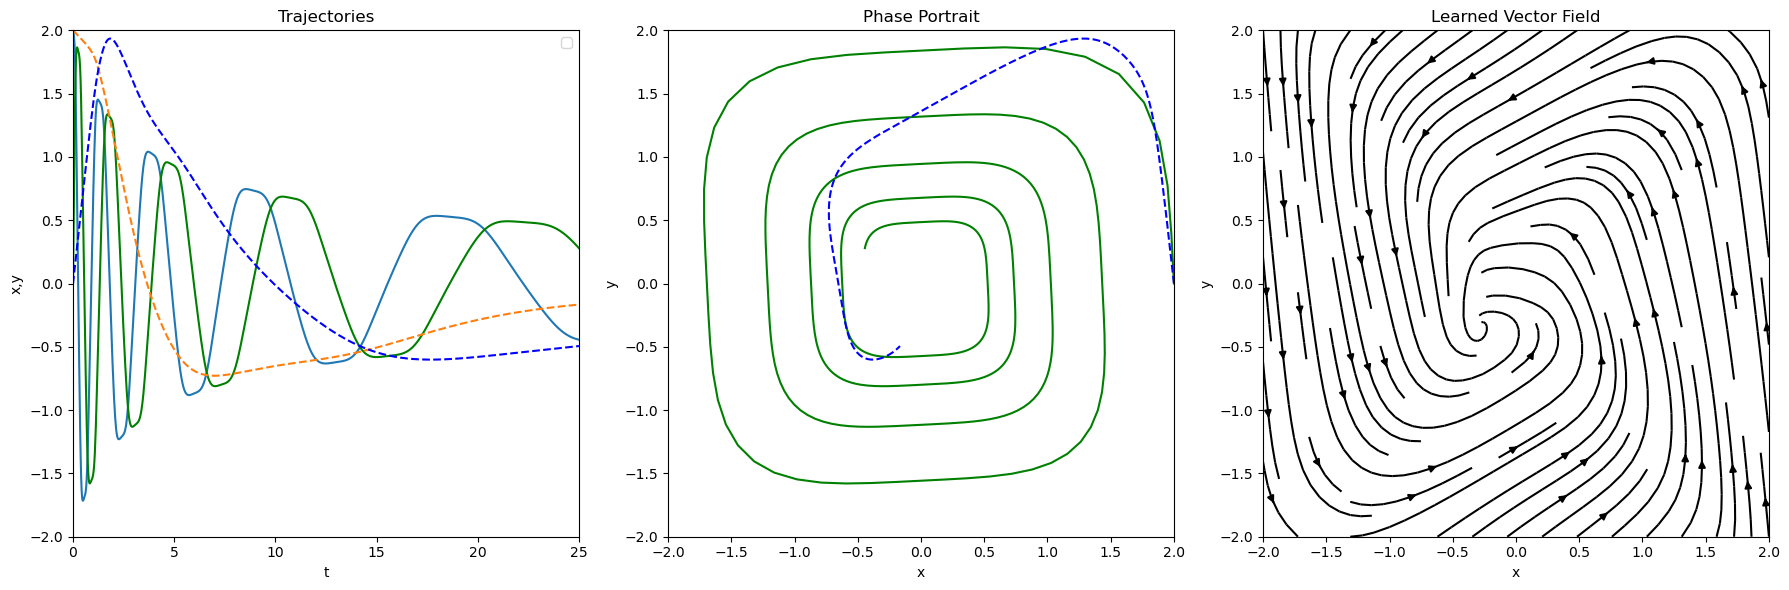

KeyboardInterrupt: 

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time 

# Define command-line arguments
class Args:
    method = 'dopri5'
    data_size = 1000
    batch_time = 10
    batch_size = 20
    niters = 2000
    test_freq = 20
    viz = True
    gpu = 0
    #adjoint = False

args = Args()

# Check GPU availability
device = torch.device('cpu')
#device = torch.device('cuda:0')
#device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# Define true ODE parameters
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., args.data_size).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

# Define the true ODE function
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

# Generate true solution
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

# Function to get a random batch
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64),
                                          args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:args.batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Function to create directories
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

# Visualization setup
if args.viz:
    makedirs('png')
    fig, (ax_traj, ax_phase, ax_vecfield) = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
    plt.show(block=False)

# Function to visualize the results
def visualize(true_y, pred_y, odefunc, itr):
   if args.viz:
        clear_output(wait=True)
        fig, (ax_traj, ax_phase, ax_vecfield) = plt.subplots(1, 3, figsize=(18, 6))

        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        plt.tight_layout()
        plt.show()

# Neural ODE model
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

# RunningAverageMeter class
class RunningAverageMeter(object):
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

# Main training loop
if __name__ == '__main__':
    ii = 0
    func = ODEFunc().to(device)
    optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
    end = time.time()
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)

    for itr in range(1, args.niters + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint(func, batch_y0, batch_t).to(device)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % args.test_freq == 0:
            with torch.no_grad():
                pred_y = odeint(func, true_y0, t)
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
                ii += 1

        end = time.time()


In [3]:
# Assuming the model has been trained and is named 'func'
learned_A_layer1 = func.net[0].weight.data.numpy()
learned_A_layer2 = func.net[2].weight.data.numpy()

print("Learned A (Layer 1):")
print(learned_A_layer1)

print("\nLearned A (Layer 2):")
print(learned_A_layer2)


Learned A (Layer 1):
[[-0.1349689  -0.05536587]
 [ 0.1037045   0.11777416]
 [-0.12072021  0.12141804]
 [ 0.11226773 -0.12659474]
 [-0.12904759 -0.08270779]
 [ 0.08018582 -0.13478418]
 [-0.11811756  0.1237882 ]
 [-0.12026103 -0.10066109]
 [ 0.1376881   0.04309687]
 [ 0.10459544 -0.12939975]
 [-0.13122745  0.10022038]
 [ 0.01675056 -0.13990764]
 [ 0.09233893  0.12449673]
 [-0.11106915 -0.11318798]
 [ 0.1093722  -0.12846498]
 [ 0.13616231 -0.08053603]
 [ 0.10296702  0.12000758]
 [ 0.13282582 -0.09812309]
 [ 0.11965342 -0.12370903]
 [-0.11442808  0.12505406]
 [-0.09243764 -0.12356862]
 [-0.10427845 -0.1185324 ]
 [-0.13027494 -0.0792775 ]
 [ 0.06921598  0.13143426]
 [ 0.11934156 -0.12260593]
 [-0.10499775 -0.11917803]
 [ 0.13989554  0.03962626]
 [ 0.10661716 -0.12942617]
 [ 0.10001224  0.11974763]
 [ 0.12661667  0.08941284]
 [ 0.11484002 -0.12588152]
 [ 0.10567173  0.11798164]
 [-0.1082918  -0.11502352]
 [-0.06769674 -0.13048789]
 [-0.10729273 -0.11580279]
 [ 0.13864015  0.03004352]
 [-0.10